In [1]:
# Calculo de la curva hipsometrica.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Examen 2/"

# Nombre del archivo de curvas.
curvas_n = "cni250kgw_unidas.csv"

# Cargamos las curvas de nivel.
curvas = pd.read_csv(path + curvas_n)
curvas["geometry"] = curvas["geometry"].apply(shp.wkt.loads)
curvas = gpd.GeoDataFrame(curvas, geometry = "geometry" )
# Las coordenadas están en WGS84 EPSG:4326.
curvas = curvas.set_crs(4326)

In [3]:
# Cargamos las Subcuencas.

# Region hidrológica a usar.
RH = "RH01"

# Cargamos archivo.
subc = gpd.read_file(path + "subcuenca.shp")
# Las coordenadas están en WGS84 EPSG:4326.
subc = subc.to_crs(4326)
# Cramos una columna con la región hidrológica.
subc["CVE_RH"] = subc["CVE_SUBCUE"].apply(lambda x: x[0:4])

# Extraemos la subcuenca con la que trabajaremos.
Subcuenca = subc[ subc["CVE_SUBCUE"] == "RH01Bd" ].reset_index(drop = True)

In [4]:
# Curvas de nivel que caen dentro de la subcuenca.
curvas[ Subcuenca.loc[0, "CVE_SUBCUE"] ] = curvas.intersection(
    Subcuenca.loc[0, "geometry"] )
subc_c = curvas.set_geometry( Subcuenca.loc[0, "CVE_SUBCUE"] ).copy()

# Eliminamos las curvas de nivel que no cruzan la subcuenca.
subc_c = subc_c[ ~ subc_c.is_empty ]

# Escogemos solo las curvas de nivel que son múltiplos de 400 m.
subc_c = subc_c[ ( subc_c["CONTOUR"] - 1) % 400 == 0 
    ].sort_values("CONTOUR", ascending = False).reset_index(drop = True)

# A coordenadas UTM 11N ESPSG:32611.
CRS = 32611
Subcuenca = Subcuenca.to_crs(CRS)
subc_c = subc_c.to_crs(CRS)
subc_c["geometry"] = subc_c["geometry"].to_crs(CRS)

# Agregamos el área.
Subcuenca["AREA"] = Subcuenca.area

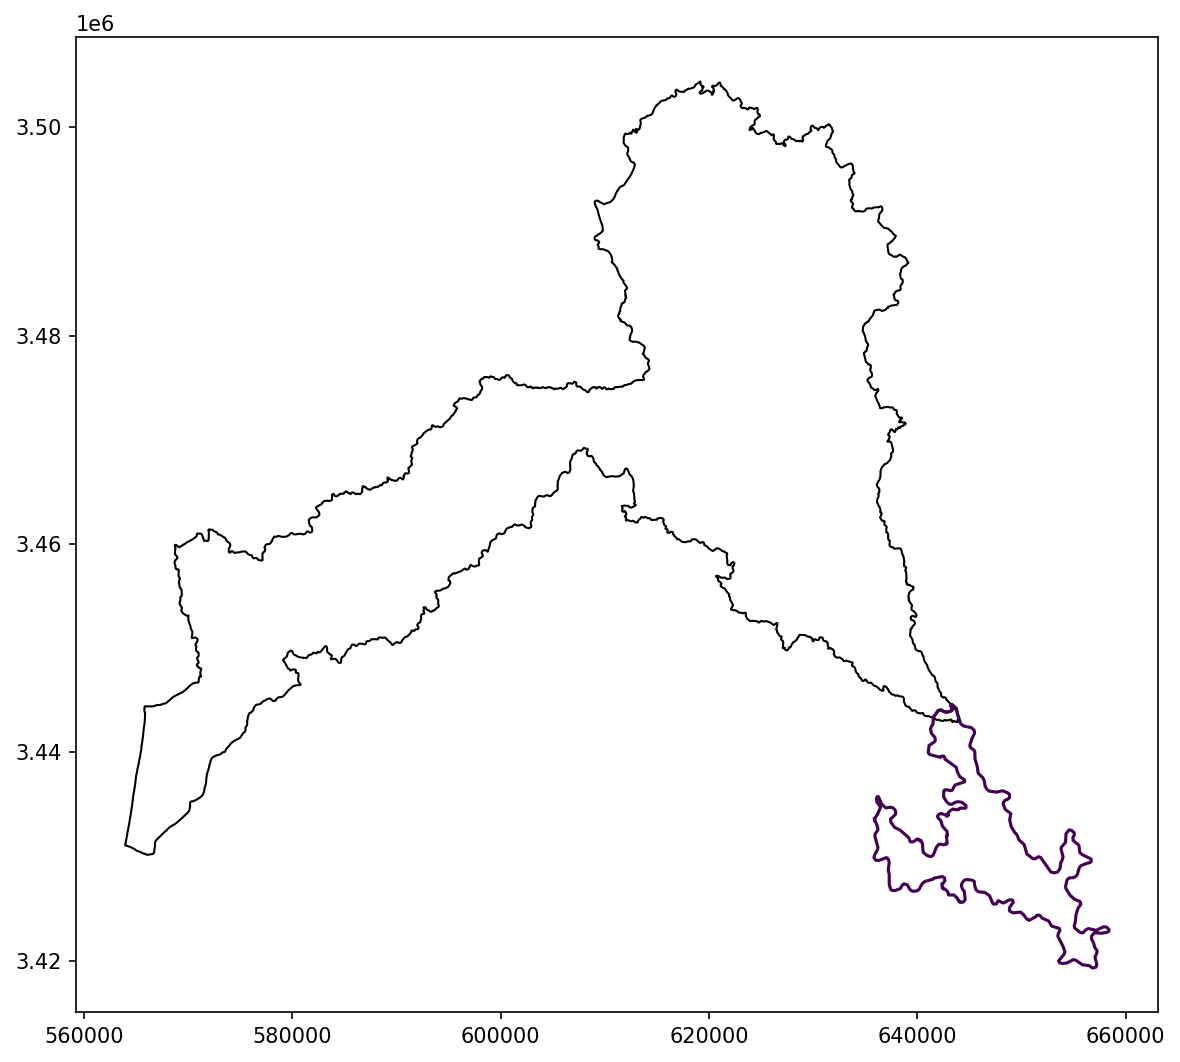

In [5]:
# Curvas de nivel individuales que cruzan la cuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las curvas de nivel individuales que cruzan la subcuenca.
subc_c.loc[[i]].plot("CONTOUR", ax = ax)
# Curvas de nivel individuales completas.
subc_c.set_geometry("geometry").loc[[i]].plot("CONTOUR", ax = ax)

fig.tight_layout()
plt.show()

(30, 6)


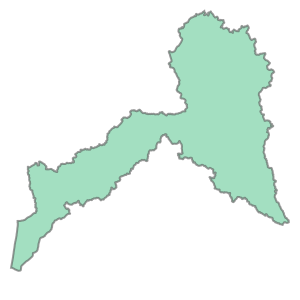

In [6]:
# Verificamos la geometría que hay que utilizar dentro
# del split para el área sobre la curva de nivel.
i = 0
j = 0

print(subc_c.shape)
shp.ops.split(Subcuenca.loc[0, "geometry"], subc_c.loc[i, "geometry"])[j]

In [7]:
# Área sobre las curvas de nivel.

# Geometrías a utilizar dentro del split
# para el área sobre las curvas de nivel.
j = [ [1, 2, 3], [1], [1], [1, 2, 3], [1, 2], [1],
      [1], [1, 2, 3, 4], [1], [1], [1], [1], [1],
      [0], [1], [1], [1], [1], [1], [1], [1], [1],
      [0], [1], [1], [1], [1], [1], [1], [0]  ]
m = []

# Iteramos para todas las isoyetas.
for i in range(subc_c.shape[0]):

    g = []
    # Curva de la isoyeta.
    l = subc_c.loc[i, "geometry"]

    # Unimos todas las geometrías del área sobre las curvas de nivel.
    for k in j[i]:
        g.append( shp.ops.split( Subcuenca.loc[0, "geometry"], l)[k] )

    # Agregamos la geometría.
    m.append( shp.geometry.MultiPolygon(g) )

# Agregamoslas geometrías creadas.
subc_c[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = m

# Calculamos el área de las área sobre las curvas de nivel
subc_c[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_c.set_geometry(
    f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY").area

In [8]:
# Curva hipsométrica.

# Niveles dentro de la subcuenca.
Z = subc_c["CONTOUR"].unique()
P_A = [None] * Z.shape[0]

# Iteramos para cada nivel
for i in range( Z.shape[0] ):
    # Sumamos el área sobre cada nivel
    # y lo dividimos entre el área de la cuenca.
    P_A[i] = ( subc_c.loc[ subc_c["CONTOUR"] == Z[i],
        f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA" ].sum()
        / Subcuenca.loc[ 0, "AREA"] ) 

# Agreamos el punto de 100%.
Z = np.concatenate([Z, [0]]) 
P_A.append(1)

# Creamos la curva hipsométrica.
hipsometrica = pd.DataFrame([Z, P_A]).T
hipsometrica.columns = ["Z", "%A"]
hipsometrica = hipsometrica.set_index("%A")

hipsometrica

,Z
%A,
0.001135,2401.0
0.004859,2001.0
0.041562,1601.0
0.205613,1201.0
0.638536,801.0
0.771939,401.0
1.000000,0.0


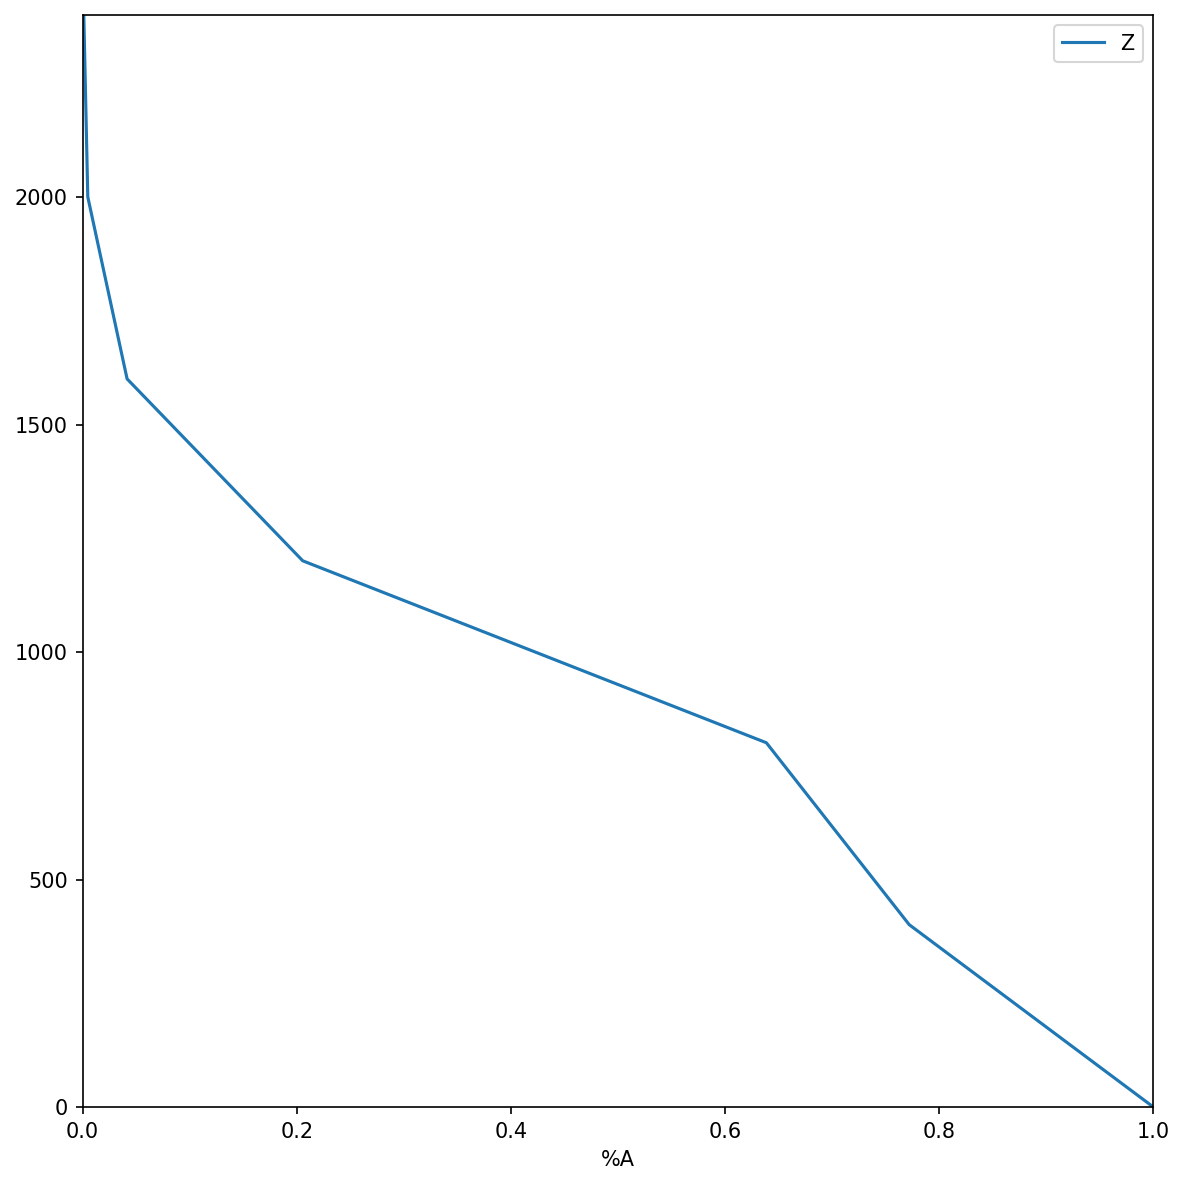

In [9]:
# Graficamos la curva hipsométrica.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos.
hipsometrica.plot( ax= ax )

# Estilo.
ax.set_xlim(0, 1)
ax.set_ylim(0, Z.max())

fig.tight_layout()
plt.show()